Using `sobol-kj` implementation of Sobol random numbers (https://github.com/sebdevine/sobol-kj), quickly hack together a test of whether a 
random catalog generated using Sobol quasi-random numbers result in $w_p$ that converges with lower $N_r$. 

In [1]:
import numpy as np 
# -- halotools -- (w_p calculation)
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import wp as WP
# -- local --
import env
from soquasirr import util as UT
from soquasirr import sobol as Sob
from ChangTools.fitstables import mrdfits

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets start with some very straightforward tests of the Sobol quasi-random vs pseudo-random

In [3]:
N_random = 100 
v1 = Sob.sobol(N_random, 2)
v2 = np.random.uniform(size=(N_random, 2))

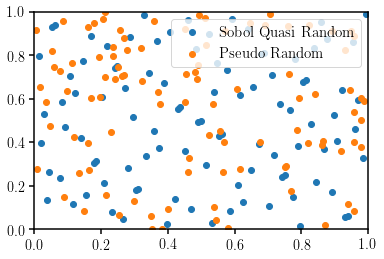

In [4]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(v1[:,0], v1[:,1], label='Sobol Quasi Random')
sub.scatter(v2[:,0], v2[:,1], label='Pseudo Random')
sub.set_xlim([0., 1.])
sub.set_ylim([0., 1.])
leg = sub.legend(loc='upper right', frameon=True, facecolor='#ffffff', prop={'size': 15})
plt.show()

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


(0.0, 2.0)

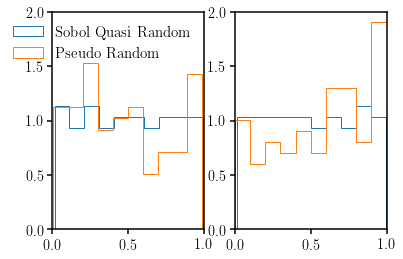

In [5]:
fig = plt.figure()
sub = fig.add_subplot(121)
_ = sub.hist(v1[:,0], histtype='step', normed=True, label='Sobol Quasi Random')
_ = sub.hist(v2[:,0], histtype='step', normed=True, label='Pseudo Random')
sub.set_xlim([0., 1.])
sub.set_ylim([0., 2.])
sub.legend(loc='upper right', prop={'size': 15})
sub = fig.add_subplot(122)
_ = sub.hist(v1[:,1], histtype='step', normed=True, label='Sobol Quasi Random')
_ = sub.hist(v2[:,1], histtype='step', normed=True, label='Pseudo Random')
sub.set_xlim([0., 1.])
sub.set_ylim([0., 2.])

cool, the figure above shows that Sobol convergers faster. 

Now lets test whether Sobol quasi-random numbers helps us out for calculating:
$$w_p = 2 \int\limits_0^{\pi_{max}} d\pi' \xi(r_p, \pi') $$ 
We first begin by generating a mock catalog in a $(250\,\mathrm{Mpc})^3$ box using `halotools`

In [6]:
model = PrebuiltHodModelFactory('tinker13', threshold = 10.25)
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift = 0, halo_finder = 'rockstar')
model.populate_mock(halocat)

This particular model is still being tested in collaboration with Jeremy Tinker.
If you need to use this prebuilt model for science, 
you will either need to test it yourself 
or wait for the Halotools developers to finish science verification.

The composite model received multiple component models 
with a new_haloprop_func_dict that use the conc_NFWmodel key. 
Ignoring the one that appears in the profile component for active_satellites galaxies


In [7]:
x = model.mock.galaxy_table['x']
y = model.mock.galaxy_table['y']
z = model.mock.galaxy_table['z']
pos = return_xyz_formatted_array(x, y, z)

In [8]:
print('%i galaxies' % len(x))

66635 galaxies


(0.0, 250.0)

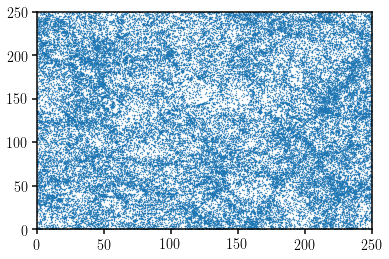

In [9]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(x, y, s=0.1)
sub.set_xlim([0., 250.])
sub.set_ylim([0., 250.])

In [10]:
pi_max = 40.
rp_bins = np.logspace(-1,1.25,15)

In [11]:
def Wp_Sobol(Nr): 
    rand = Sob.sobol(Nr, 3)
    rand[:,0] *= 250. 
    rand[:,1] *= 250. 
    rand[:,2] *= 250. 
    
    w_p = WP(pos, rp_bins, pi_max, randoms=rand, estimator='Landy-Szalay', num_threads='max')
    return w_p

In [12]:
def Wp_Pseudo(Nr): 
    rand = np.random.uniform(size=(Nr, 3))
    rand[:,0] *= 250. 
    rand[:,1] *= 250. 
    rand[:,2] *= 250. 
    
    w_p = WP(pos, rp_bins, pi_max, randoms=rand, estimator='Landy-Szalay', num_threads='max')
    return w_p

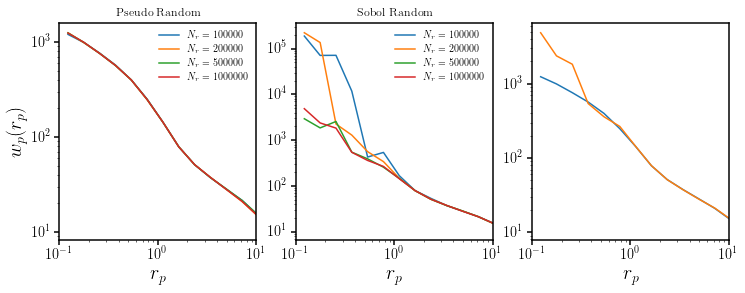

In [14]:
fig = plt.figure(figsize=(12,4)) 
sub1 = fig.add_subplot(131)
sub2 = fig.add_subplot(132)

for Nr in [100000, 200000, 500000, 1000000]: 
    wp_p = Wp_Pseudo(Nr)
    sub1.plot(0.5*(rp_bins[:-1] + rp_bins[1:]), wp_p, label='$N_r='+str(Nr)+'$')
    wp_s = Wp_Sobol(Nr)
    sub2.plot(0.5*(rp_bins[:-1] + rp_bins[1:]), wp_s, label='$N_r='+str(Nr)+'$')
sub1.set_xscale('log')
sub1.set_xlim([1e-1, 1e1])
sub1.set_xlabel(r'$r_p$', size=20)
sub1.set_yscale('log')
sub1.set_ylabel(r'$w_p(r_p)$', size=20)
sub1.legend(loc='upper right')
sub1.set_title('Pseudo Random')

sub2.set_xscale('log')
sub2.set_xlim([1e-1, 1e1])
sub2.set_xlabel(r'$r_p$', size=20)
sub2.set_yscale('log')
#sub2.set_ylabel(r'$w_p(\theta)$', size=20)
sub2.legend(loc='upper right')
sub2.set_title('Sobol Random')

sub = fig.add_subplot(133)
sub.plot(0.5*(rp_bins[:-1] + rp_bins[1:]), wp_p)
sub.plot(0.5*(rp_bins[:-1] + rp_bins[1:]), wp_s)
sub.set_xscale('log')
sub.set_xlim([1e-1, 1e1])
sub.set_xlabel(r'$r_p$', size=20)
sub.set_yscale('log')
sub.legend(loc='upper right')